In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import thomsonpy.thomson_scattering.thomson_scattering_tools as thtools
import thomsonpy.data_management.formatter as fmt
import thomsonpy.data_management.fragmenter as frm
import thomsonpy.data_management.octree.octree as octr
import thomsonpy.data_management.visualizer as vis
import thomsonpy.config.paths as paths
import thomsonpy.config.solar_imager_params as sip
import thomsonpy.config.thomson_scattering_params as tsp
import thomsonpy.constants.units as units

In [ ]:
prefix = "../../"
predsci_data_filepath = prefix + paths.PREDSCI_DATA_PATH + paths.PREDSCI_FILENAME
octree_data_filepath = f"{prefix}{paths.OCTREE_DATA_PATH}{os.path.splitext(paths.PREDSCI_FILENAME)[0]}.data"
octrees_path = prefix + paths.OCTREES_PATH 

In [ ]:
# DATA FRAGMENTING
print("\nStarting data formatting and fragmenting...")

ne_raw = frm.get_ne_raw(predsci_data_filepath)
data_radial = frm.get_ne_raw_coords(predsci_data_filepath, "radial")
data_theta = frm.get_ne_raw_coords(predsci_data_filepath, "theta")
data_phi = frm.get_ne_raw_coords(predsci_data_filepath, "phi")

ini_time = time.perf_counter()
octree_data = []
octree_data = frm.fragment(frm.selection, ne_raw, data_radial, data_theta, data_phi)
fin_time = time.perf_counter()

print("Data formatting and fragmentation in", fin_time - ini_time, "seconds.")

fmt.dump(octree_data_filepath, octree_data)
print(f"Stored data for octree at {paths.OCTREE_DATA_PATH}")

print("Octree will have", len(octree_data), "points")

In [ ]:
vis.vis_octree_data(octree_data_filepath)

In [ ]:
vis.vis_ne(octree_data_filepath)

In [ ]:
import os
import time

import thomsonpy.config.octree_params as op

## OCTREE CREATION AND STORAGE
min_v = [op.MIN_1, op.MIN_2, op.MIN_3, op.MIN_4]
max_v = [op.MAX_1, op.MAX_2, op.MAX_3, op.MAX_4]

i = 0
# Loading data...
octree_data = fmt.load(octree_data_filepath)
print("Loaded octree data:", len(octree_data), "points.")
octree = 0

In [ ]:
# Creating octree...
print("Creating octree with params:")
print("MAX_LEVEL =", op.MAX_LEVEL)
print("MAX_DATA =", op.MAX_DATA)
print("MIN_V =", min_v[i])
print("MAX_V =", max_v[i])
ini_time = time.perf_counter()
octree = octr.Octree(op.MAX_LEVEL, op.MAX_DATA, octree_data, min_v[i], max_v[i])
fin_time = time.perf_counter()
print("Octree " + str(i + 1) + " built in", str((fin_time - ini_time) / 60), "minutes.")
octr.Octree.save(octree, octrees_path + "octree_" + str(i + 1) + ".oct")
print("Octree " + str(i + 1) + " created at", paths.OCTREES_PATH)

In [ ]:
octree = octr.Octree.load(octrees_path + "octree_1.oct")
vis.vis_octree(octree)

In [ ]:
"""
Starts execution of solar corona modeling with the Predictive Science model.
"""
print("Imaging between", sip.IMAGE_MIN * units.METERS_TO_RSOL, "RSol and" , sip.IMAGE_MAX * units.METERS_TO_RSOL, "RSol.")
print("Resolution = ", sip.IMAGE_RESOLUTION / 1000, " km (", sip.IMAGE_NUM_POINTS, "x", sip.IMAGE_NUM_POINTS, ").")
x_values = np.linspace(sip.MIN_COORD, sip.MAX_COORD, sip.IMAGE_NUM_POINTS) # de - a +
#print(x_values * units.METERS_TO_RSOL)
y_values = np.linspace(sip.MIN_COORD, sip.MAX_COORD, sip.IMAGE_NUM_POINTS)[::-1] # de + a -
#print(y_values * units.METERS_TO_RSOL)
model = np.zeros((sip.IMAGE_NUM_POINTS, sip.IMAGE_NUM_POINTS))
print("# Numeric integral steps =", tsp.NUM_Z)

In [ ]:
# Quadrant 1
print("Loading octree...")
NE_MODEL = octr.Octree.load(octrees_path + "octree_1.oct")
print("Octree loaded.")

num_points = sip.IMAGE_NUM_POINTS * sip.IMAGE_NUM_POINTS
print(f"Num points = {num_points}")
count = 0

ini_time = time.perf_counter()

for y in range(sip.IMAGE_NUM_POINTS):
    for x in range(sip.IMAGE_NUM_POINTS):
        if (x_values[x]**2 + y_values[y]**2) > tsp.SOLAR_RADIUS**2:
            # Coordinates with the center of the Sun as Origin of the Reference System.
            target = (x_values[x], y_values[y], 0)
            #print(target * units.METERS_TO_RSOL)
            # Creates a ThomsonGeometry object to manage the ray - tracing across the Corona.
            TG = thtools.ThomsonGeometry(sip.SUN_CENTER, sip.OBSERVER, target, tsp.SOLAR_RADIUS)

            # Line of sight integration generating a value for the scattered light model.
            scattered_light = thtools.get_scattered_light(tsp.WAVELENGTH, tsp.T_SOL, tsp.X, TG.get_elongation(), tsp.INI_Z, tsp.FIN_Z, tsp.INCR_Z, TG, NE_MODEL)
            model[y][x] = scattered_light
        else:
            model[y][x] = 0

        # Progress
        count += 1
        if count % 10000 == 0:
            print("Progress", count / num_points * 100,"%")

fin_time = time.perf_counter()
print("Model built in", str((fin_time - ini_time) / 60), "minutes.")

fmt.dump(f"../../{paths.MODELS_PATH}predsci_test_739p_16steps.np", model)


/tmp/ipykernel_7285/245009991.py:28: RuntimeWarning: divide by zero encountered in log
  model_log = np.log(model) / np.log(7)


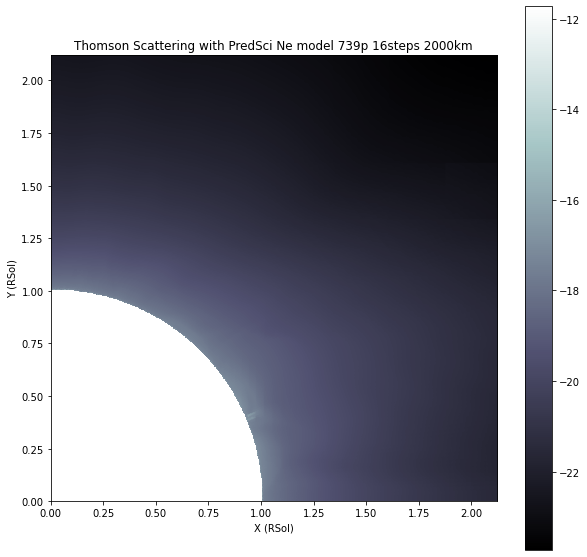

In [74]:
"""
Visualization of the ThomsonScattering.
"""
"""
cmap
['rainbow', 'nipy_spectral', 'gist_ncar', 'viridis', 'twilight', 'twilight_shifted', 'bone']
"""

"""
interpolation
'none', 'antialiased', 'nearest', 'bilinear', 
'bicubic', 'spline16', 'spline36', 'hanning', 
'hamming', 'hermite', 'kaiser', 'quadric', 
'catrom', 'gaussian', 'bessel', 'mitchell', 
'sinc', 'lanczos', 'blackman'

"""

"""
interpolation_stage{'data', 'rgba'}, default: 'data'
"""
model = fmt.load(f"../../{paths.MODELS_PATH}predsci_test_739p_16steps.np")

plt.figure(figsize=(10, 10))
plt.title("Thomson Scattering with PredSci Ne model 739p 16steps 2000km")
plt.ylabel("Y (RSol)")
plt.xlabel("X (RSol)")
model_log = np.log(model) / np.log(7) 
plt.imshow(model_log, 
           cmap = 'bone', 
           interpolation = 'antialiased',
           interpolation_stage = 'data',
#           vmin = -20, 
#           vmax = -15,
           extent=[sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL, sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL])
plt.colorbar()

In [70]:
"""
Models comparison
"""
def imshow_model(model, description, ax, fig, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
                                  
    im = ax.imshow(model, **kwargs)

    ax.set_xlabel(f" X [RSol]") # Set the axis label in the form "Variable description [units]"
    ax.set_ylabel(f" Y [RSol]") # Set the axis label in the form "Variable description [units]"
    ax.set_title(description)

    #ax.legend()
    fig.colorbar(im, cax = cax, orientation = 'vertical')

/tmp/ipykernel_7285/2902632900.py:9: RuntimeWarning: divide by zero encountered in log
  my_models = [np.divide(np.log(i), np.log(10)) for i in my_models]


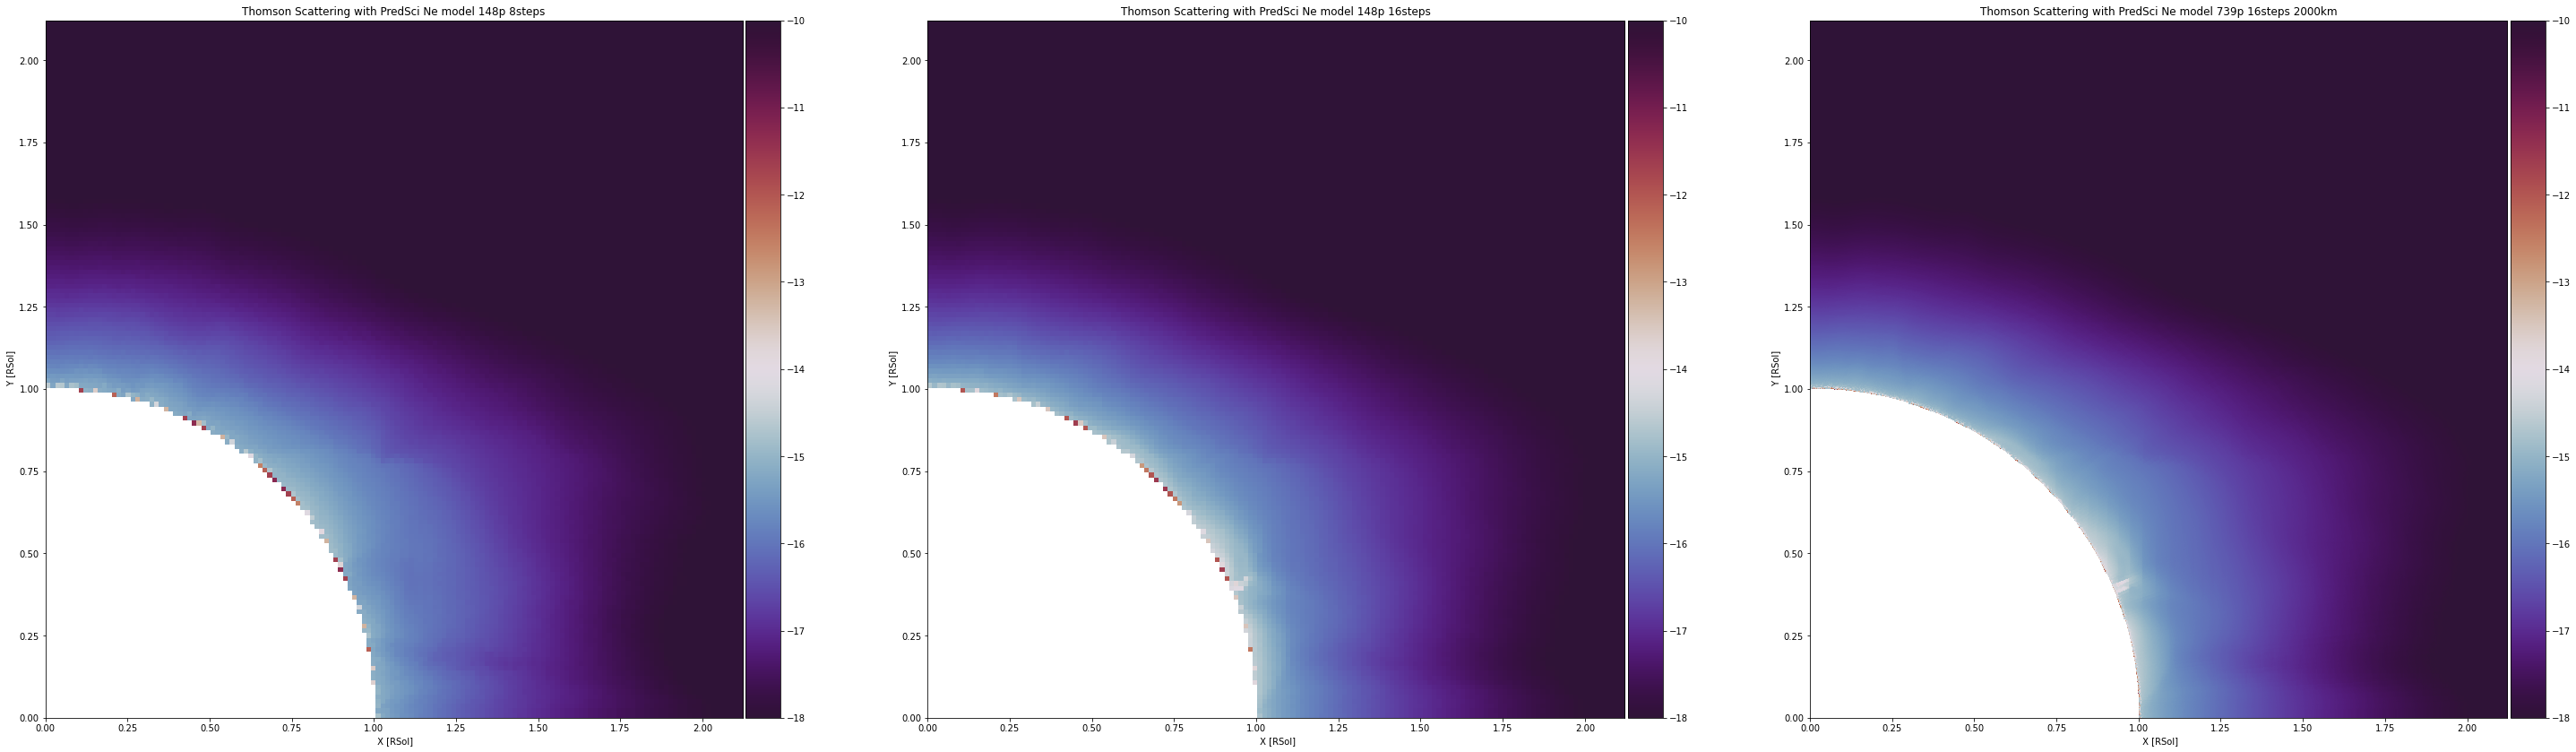

In [106]:
model_739p_16steps = fmt.load(f"../../{paths.MODELS_PATH}predsci_test_739p_16steps.np")
model_148p_16steps = fmt.load(f"../../{paths.MODELS_PATH}predsci_octree_148p_16steps.np")
model_148p_8steps = fmt.load(f"../../{paths.MODELS_PATH}predsci_octree_148p_8steps.np")
desc1 = "Thomson Scattering with PredSci Ne model 148p 8steps"
desc2 = "Thomson Scattering with PredSci Ne model 148p 16steps"
desc3 = "Thomson Scattering with PredSci Ne model 739p 16steps 2000km"

my_models = [model_148p_8steps, model_148p_16steps, model_739p_16steps]
my_models = [np.divide(np.log(i), np.log(10)) for i in my_models] 
my_desc = [desc1, desc2, desc3]
my_cmap = 'twilight_shifted'
my_interp = 'antialiased'
my_interp_stage = 'data'
my_vmin = -18
my_vmax = -10
my_extent = [sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL, sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL]

fig, ax = plt.subplots(ncols=3, figsize=(50, 40))   # We can select ncols, nrows, or both.

for i in range(3):
    imshow_model(my_models[i], my_desc[i], ax[i], fig, cmap = my_cmap, interpolation = my_interp, vmin = my_vmin, vmax = my_vmax, interpolation_stage = my_interp_stage, extent = my_extent)


In [ ]:
fig.savefig(f"../../{paths.MODELS_PATH}predsci_comparison.jpg")